In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.4 MB/s eta 0:00:0

In [ ]:
!nvidia-smi

Mon Apr 24 00:26:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

ModuleNotFoundError: ignored

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model_ckpt = "google/pegasus-xsum"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [ ]:
def calculate_score(dataset, metric, model, tokenizer, batch_size, device=device, doc, summary):
    # chunk to batches to increase speed
    doc_batches = list(into_batches(dataset[doc], batch_size))
    summary_batches = list(into_batches(dataset[summary], batch_size))
    # use tqdm to visualize the calculation progress
    total_len = len(doc_batches)
    for doc_batch, summary_batch in tqdm(zip(doc_batches, summary_batches), total=total_len):
        # For Xsum, max_length is 512; For CNN, max_length is 1024
        inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
        # For Xsum, max_length is 64; For CNN, max_length is 128; Other parameters are set as suggested in the paper
        outputs = model.generate(input_ids=inputs["input_ids"].to(device),attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        # Decode the generated texts
        decoded_summaries = [tokenizer.decode(sum, skip_special_tokens=True, clean_up_tokenization_spaces=True) for sum in outputs]      
        # Do the rouge calculation
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    #return the final score
    score = metric.compute()
    return score

### Load data

Link: https://huggingface.co/datasets/xsum

In [ ]:
dataset_xsum = load_dataset("xsum")

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset_cnn = load_dataset('cnn_dailymail', '3.0.0')

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset_xsum

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [ ]:
dataset_cnn

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
split_lengths_xsum = [len(dataset_xsum[split])for split in dataset_xsum]
split_lengths_cnn = [len(dataset_cnn[split])for split in dataset_cnn]

In [ ]:
split_lengths_xsum

[204045, 11332, 11334]

In [ ]:
split_lengths_cnn

[287113, 13368, 11490]

In [ ]:
dataset_xsum['train'].column_names

['document', 'summary', 'id']

In [ ]:
dataset_cnn['train'].column_names

['article', 'highlights', 'id']

In [ ]:
print(dataset_xsum["test"][1]["document"])
print("\n")
print(dataset_xsum["test"][1]["summary"])
print(dataset_xsum["test"][1]["id"])

Officers searched properties in the Waterfront Park and Colonsay View areas of the city on Wednesday.
Detectives said three firearms, ammunition and a five-figure sum of money were recovered.
A 26-year-old man who was arrested and charged appeared at Edinburgh Sheriff Court on Thursday.


A man has appeared in court after firearms, ammunition and cash were seized by police in Edinburgh.
34227252


In [ ]:
print(dataset_cnn["test"][1]["article"])
print("\n")
print(dataset_cnn["test"][1]["highlights"])
print(dataset_cnn["test"][1]["id"])

(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguided mercy killing and then buried in a field -- only to survive. That's according to Washington State University, where the dog -- a friendly white-and-black bully breed mix now named Theia -- has been receiving care at the Veterinary Teaching Hospital. Four days after her apparent death, the dog managed to stagger to a nearby farm, dirt-covered and emaciated, where she was found by a worker who took her to a vet for help. She was taken in by Moses Lake, Washington, resident Sara Mellado. "Considering everything that she's been through, she's incredibly gentle and loving," Mellado said, according to WSU News. "She's a true miracle dog and she deserves a good life." Theia is only one year old but the dog's brush with death did not leave her unscathed. She suffered a dislocated jaw, leg injuries a

# Evaluating PEGASUS on XSUM

In [ ]:
dataset_xsum['test'][1]['document']

'Officers searched properties in the Waterfront Park and Colonsay View areas of the city on Wednesday.\nDetectives said three firearms, ammunition and a five-figure sum of money were recovered.\nA 26-year-old man who was arrested and charged appeared at Edinburgh Sheriff Court on Thursday.'

In [ ]:
len(dataset_xsum['test'][1]['document'])

287

In [ ]:
len(dataset_xsum['test'][0]['document'])

3525

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_xsum['test'][1]['document'] )

print(pipe_out)

Your max_length is set to 64, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


[{'summary_text': 'A man has been charged after firearms and money were seized by police in Edinburgh.'}]


In [ ]:
pipe_out = pipe(dataset_xsum['test'][0]['document'],truncation=True)

print(pipe_out)

[{'summary_text': 'There is a "desperate need" for more affordable housing for men leaving prison in Wales, a charity has said.'}]


In [ ]:
#print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_xsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'document', column_summary='summary', batch_size=8)

100%|██████████| 1417/1417 [1:35:41<00:00,  4.05s/it]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus_xsum'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus_xsum,0.021865,0.000227,0.02177,0.021769


# Histogram

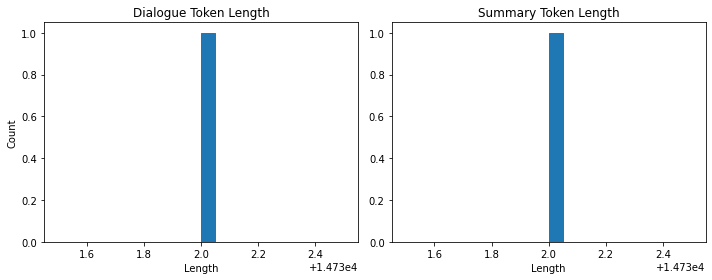

In [ ]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

  0%|          | 0/15 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3547: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM

/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM


In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

In [ ]:

trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()


The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, dialogue, id. If summary, dialogue, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__ca

Step,Training Loss,Validation Loss
500,1.690200,1.488429


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, dialogue, id. If summary, dialogue, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=920, training_loss=1.828826087454091, metrics={'train_runtime': 2707.8434, 'train_samples_per_second': 5.44, 'train_steps_per_second': 0.34, 'total_flos': 5526961323663360.0, 'train_loss': 1.828826087454091, 'epoch': 1.0})

In [ ]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 410/410 [13:08<00:00,  1.92s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018618,0.000297,0.018493,0.018518


In [ ]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

Configuration saved in pegasus-samsum-model/config.json
Model weights saved in pegasus-samsum-model/pytorch_model.bin


In [ ]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

tokenizer config file saved in tokenizer/tokenizer_config.json
Special tokens file saved in tokenizer/special_tokens_map.json


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Test

In [ ]:
dataset_samsum = load_dataset("samsum")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

loading file spiece.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

loading configuration file pegasus-samsum-model/config.json
Model config PegasusConfig {
  "_name_or_path": "pegasus-samsum-model",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "l

In [ ]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.
